In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import sys
sys.path.append('../')
from simulate_frbs import *
from plotting import *
import scipy.signal
from Pipeline import DPA


In [2]:
def sgolay2d ( z, window_size, order, derivative=None):
    """
    """
    # number of terms in the polynomial expression
    n_terms = ( order + 1 ) * ( order + 2)  / 2.0

    if  window_size % 2 == 0:
        raise ValueError('window_size must be odd')

    if window_size**2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2

    # exponents of the polynomial. 
    # p(x,y) = a0 + a1*x + a2*y + a3*x^2 + a4*y^2 + a5*x*y + ... 
    # this line gives a list of two item tuple. Each tuple contains 
    # the exponents of the k-th term. First element of tuple is for x
    # second element for y.
    # Ex. exps = [(0,0), (1,0), (0,1), (2,0), (1,1), (0,2), ...]
    exps = [ (k-n, n) for k in range(order+1) for n in range(k+1) ]

    # coordinates of points
    ind = np.arange(-half_size, half_size+1, dtype=np.float64)
    dx = np.repeat( ind, window_size )
    dy = np.tile( ind, [window_size, 1]).reshape(window_size**2, )

    # build matrix of system of equation
    A = np.empty( (window_size**2, len(exps)) )
    for i, exp in enumerate( exps ):
        A[:,i] = (dx**exp[0]) * (dy**exp[1])

    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2*half_size, z.shape[1] + 2*half_size
    Z = np.zeros( (new_shape) )
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] =  band -  np.abs( np.flipud( z[1:half_size+1, :] ) - band )
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band  + np.abs( np.flipud( z[-half_size-1:-1, :] )  -band )
    # left band
    band = np.tile( z[:,0].reshape(-1,1), [1,half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs( np.fliplr( z[:, 1:half_size+1] ) - band )
    # right band
    band = np.tile( z[:,-1].reshape(-1,1), [1,half_size] )
    Z[half_size:-half_size, -half_size:] =  band + np.abs( np.fliplr( z[:, -half_size-1:-1] ) - band )
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z

    # top left corner
    band = z[0,0]
    Z[:half_size,:half_size] = band - np.abs( np.flipud(np.fliplr(z[1:half_size+1,1:half_size+1]) ) - band )
    # bottom right corner
    band = z[-1,-1]
    Z[-half_size:,-half_size:] = band + np.abs( np.flipud(np.fliplr(z[-half_size-1:-1,-half_size-1:-1]) ) - band )

    # top right corner
    band = Z[half_size,-half_size:]
    Z[:half_size,-half_size:] = band - np.abs( np.flipud(Z[half_size+1:2*half_size+1,-half_size:]) - band )
    # bottom left corner
    band = Z[-half_size:,half_size].reshape(-1,1)
    Z[-half_size:,:half_size] = band - np.abs( np.fliplr(Z[-half_size:, half_size+1:2*half_size+1]) - band )

    # solve system and convolve
    if derivative == None:
        m = np.linalg.pinv(A)[0].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, m, mode='valid')
    elif derivative == 'col':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -c, mode='valid')
    elif derivative == 'row':
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid')
    elif derivative == 'both':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid'), scipy.signal.fftconvolve(Z, -c, mode='valid')

In [237]:
directories = [
    "correct_noise_simple_broad",
    "correct_noise_simple_narrow",
    "correct_noise_scattered",
    "correct_noise_complex",
    "correct_noise_drifting"
]

data = []

for directory in directories:
    data_dir = f"/Users/dirkkuiper/Documents/MacBookProDocuments/University/Thesis/Rep_Learn_FRB/{directory}"
    data_per_directory = []

    for filename in os.listdir(data_dir):
        if filename.endswith(".npy"):
            # data_per_directory.append(sgolay2d( np.load(os.path.join(data_dir, filename)), window_size=99, order=4))
            dynamic_spectra_w_pulse = np.load(os.path.join(data_dir, filename))
            dynamic_spectra_w_pulse = dynamic_spectra_w_pulse[300:-300, :]
            # print(dynamic_spectra_w_pulse.shape)
            mean = np.mean(dynamic_spectra_w_pulse) 
            std = np.std(dynamic_spectra_w_pulse)
            threshold = mean + 1 * std
            
            # plot_dynamic_spectra(dynamic_spectra_w_pulse)
            # Apply thresholding
            # dynamic_spectra_w_pulse[dynamic_spectra_w_pulse < threshold] = 0
            scaler = StandardScaler()
            dynamic_spectra_w_pulse = scaler.fit_transform(dynamic_spectra_w_pulse)
            # plot_dynamic_spectra(dynamic_spectra_w_pulse, 'Dynamic Spectra Clipped')

            # sys.exit()

            data_per_directory.append(dynamic_spectra_w_pulse)

            # plot_dynamic_spectra(np.load(os.path.join(data_dir, filename)))
            # print('next')
            # plot_dynamic_spectra(sgolay2d( np.load(os.path.join(data_dir, filename)), window_size=99, order=4))

    data_per_directory = np.array(data_per_directory).reshape(-1, (1024 - 600) * 512)[:100]
    data.append(data_per_directory)

# Combine the data from all directories into one array
combined_data = np.concatenate(data, axis=0)

# Reshape the combined data for PCA
combined_data_2d = combined_data.reshape(-1, (1024 - 600) * 512)

print(combined_data_2d.shape)


(500, 217088)


In [226]:
print(combined_data_2d.max())


13.043461


In [233]:
# Apply PCA to the combined data
n_components = 2  # You can adjust the number of components as needed
pca = PCA(n_components=n_components)
fit = pca.fit(combined_data_2d)
transformed_fit = pca.fit_transform(combined_data_2d)



In [177]:
# Reconstruct the burst data from the transformed PCA fit
reconstructed_data = pca.inverse_transform(transformed_fit)

# Reshape the reconstructed data to its original shape
reconstructed_data_reshaped = reconstructed_data.reshape(-1, 1024 * 512)

print(reconstructed_data_reshaped.shape)

(500, 524288)


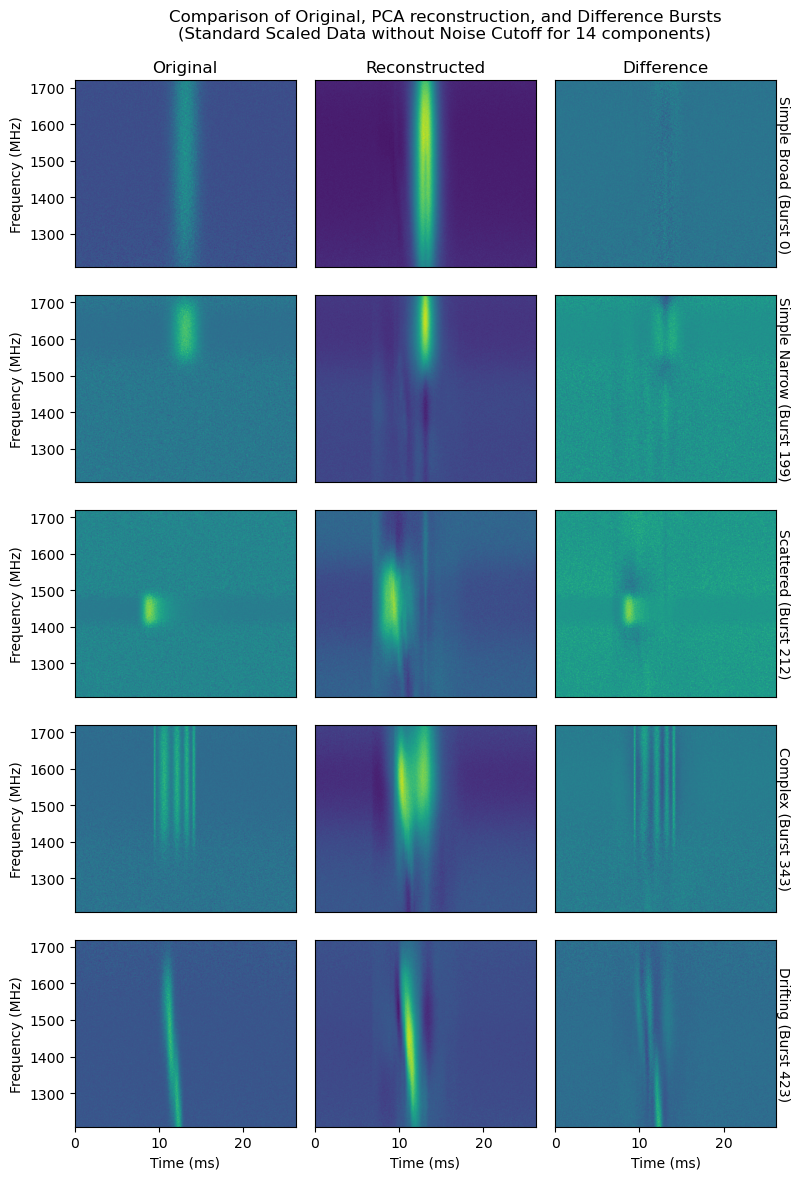

In [181]:
# Choose bursts from each class
class_indices = [0, 199, 212, 343, 423]

# Create a figure with five rows and three columns of subplots
fig, axs = plt.subplots(5, 3, figsize=(9, 12), sharex=True, sharey=True)

class_labels = ["Simple Broad", "Simple Narrow", "Scattered", "Complex", "Drifting"]

for i, (class_index, label) in enumerate(zip(class_indices, class_labels)):
    for j, plot_type in enumerate(['Original', 'Reconstructed', 'Difference']):
        # Extract the burst data from the original and reconstructed data
        original_burst = combined_data_2d[class_index]
        reconstructed_burst = reconstructed_data_reshaped[class_index]

        # Reshape the burst data to its original shape (1024 samples x 512 channels)
        original_burst = original_burst.reshape(1024, 512)
        reconstructed_burst = reconstructed_burst.reshape(1024, 512)

        # Calculate the difference between original and reconstructed bursts
        difference_burst = original_burst - reconstructed_burst

        # Plot the burst in the corresponding subplot
        if plot_type == 'Original':
            data_to_plot = original_burst
        elif plot_type == 'Reconstructed':
            data_to_plot = reconstructed_burst
        else:
            data_to_plot = difference_burst

        time_step = 0.0000256  # Default time step in seconds
        freq_labels = np.linspace(1208, 1720, original_burst.shape[1])
        extent = [0, original_burst.shape[0] * time_step * 1000, freq_labels[0], freq_labels[-1]]

        # Plot the burst in the corresponding subplot
        img = axs[i, j].imshow(data_to_plot.T, aspect="auto", cmap="viridis", extent=extent)

        # Set labels based on plot type
        if j == 0:
            axs[i, j].set_ylabel('Frequency (MHz)')
        else:
            axs[i,j].tick_params(left=False,labelleft=False)
        
        if i == 0:
            axs[i, j].set_title(f'{plot_type}')

        if i == 4:
            axs[i, j].set_xlabel('Time (ms)')
        else:
            axs[i,j].tick_params(bottom=False,labelbottom=False)

# Add labels to the right of each row
    axs[i, 2].text(1, 0.5, f'{label} (Burst {class_index})', transform=axs[i, 2].transAxes, va='center', rotation=-90)

# Adjust layout for better visualization
plt.tight_layout(rect=[0, 0, 0.9, 0.95])

# Add an overall title
plt.suptitle('Comparison of Original, PCA reconstruction, and Difference Bursts\n(Standard Scaled Data without Noise Cutoff for 14 components)')

# Show the plot
plt.show()


In [90]:
print(transformed_fit.shape)

(500, 2)


## DPA on PCA

In [48]:
est = DPA.DensityPeakAdvanced(Z=1.5)
est.fit(transformed_fit)

DensityPeakAdvanced(Z=1.5)

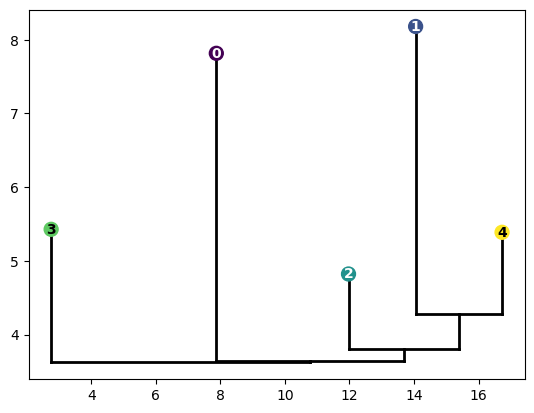

In [49]:
est.get_dendrogram()

In [56]:
label_to_find = 1

# Find indices of bursts with the specified label
burst_indices = np.where(est.labels_ == label_to_find)[0]

# Filter indices based on the specified range (300 to 399)
filtered_indices = [idx for idx in burst_indices if 300 <= idx <= 399]

# Plot the dynamic spectrum for each burst with the specified label and within the specified range
for idx in filtered_indices:
    print(idx)
    # dynamic_spectrum = combined_data_2d[idx].reshape(512, 1024)  # Adjust the shape based on your data dimensions
    # plot_dynamic_spectra(dynamic_spectrum)

306
308
311
327
330
339
354
356
362
364
376
384
388
389
394


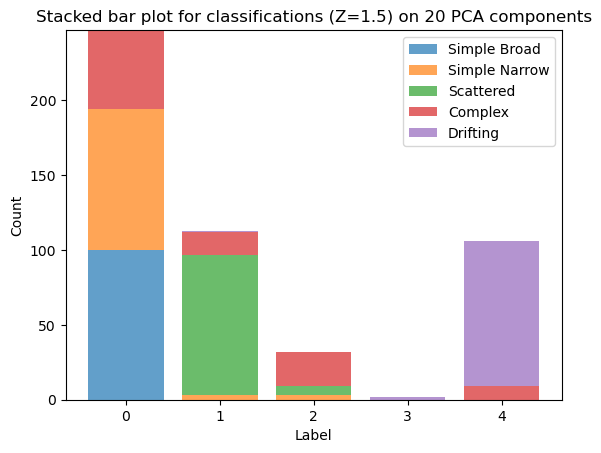

In [62]:
labels = [label if label >= 0 else 10 for label in est.labels_]


# Number of classes (assuming each class has 100 labels)
num_classes = int(len(labels) / 100)

# Reshape the labels into a 2D array where each row corresponds to a class
labels_2d = np.array(labels).reshape(num_classes, -1)

# Count the occurrences of each label in each class
class_counts = [np.bincount(class_labels, minlength=np.max(labels) + 1) for class_labels in labels_2d]

# Plot a stacked bar plot for each class
bottom = np.zeros(np.max(labels) + 1)
for i, counts in enumerate(class_counts):
    plt.bar(range(len(counts)), counts, bottom=bottom, alpha=0.7, label=f'Class {i}')
    bottom += counts

class_names = ["Simple Broad", "Simple Narrow", "Scattered", "Complex", "Drifting"]

plt.xlabel('Label')
plt.ylabel('Count')
plt.legend(class_names)
plt.title('Stacked bar plot for classifications (Z=1.5) on 20 PCA components')
plt.show()


In [348]:
# Define labels for each directory
labels = [
    "Simple Broad",
    "Simple Narrow",
    "Scattered",
    "Complex",
    "Drifting"
]

# Set the figure size
plt.figure(figsize=(10, 6))
print(transformed_fit.shape)

# Create a scatter plot where points are colored by directory labels
for i, label in enumerate(directories):
    num_samples = data[i].shape[0]
    start_idx = sum(len(data[j]) for j in range(i))
    end_idx = start_idx + num_samples
    plt.scatter(transformed_fit[start_idx:end_idx, 0], transformed_fit[start_idx:end_idx, 2], label=labels[i], s=20)

# Set axis labels
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Set a title for the plot
plt.title('PCA Results for dynamic spectra w standardscaler variable background noise 424 timesteps')

# Display a legend to differentiate the datasets
plt.legend()

# Show the plot
plt.show()

(500, 2)


IndexError: index 2 is out of bounds for axis 1 with size 2

<Figure size 1000x600 with 0 Axes>

## PCA colored by DPA clusters

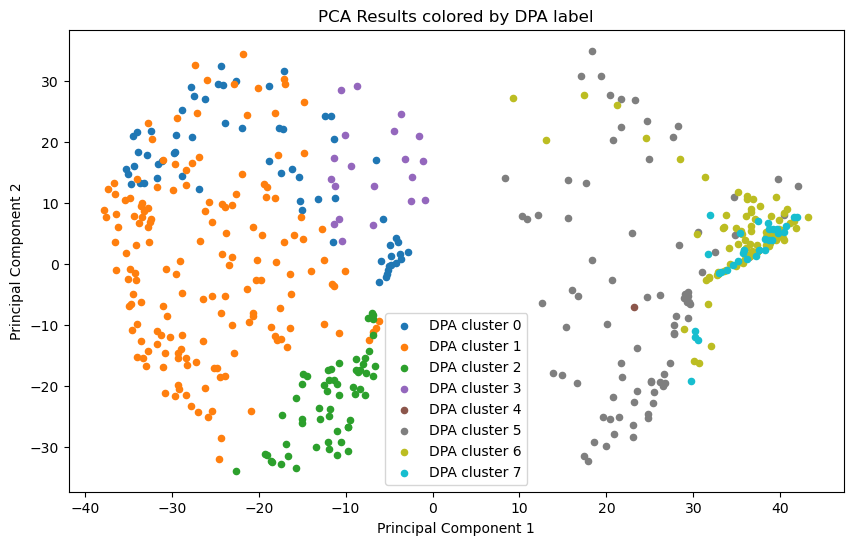

In [45]:
labels = [1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 0, 1, 1, 1, 1, 0, 1, 0,
       2, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 0, 1, 1,
       0, 0, 3, 1, 0, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 3, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 2, 2, 2, 0, 1, 1, 2, 1, 1, 1, 3, 1, 1, 2, 2, 1, 0, 2, 0,
       1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 0, 2, 1, 0, 1, 0, 1, 2, 2, 1,
       2, 2, 2, 0, 1, 2, 0, 0, 2, 2, 1, 0, 1, 2, 2, 2, 0, 0, 0, 2, 1, 0,
       2, 0, 3, 2, 1, 3, 1, 1, 2, 3, 2, 2, 3, 0, 2, 2, 0, 1, 2, 2, 1, 0,
       2, 3, 1, 2, 3, 3, 0, 1, 3, 1, 1, 2, 2, 0, 3, 1, 2, 1, 2, 1, 3, 2,
       0, 0, 1, 2, 2, 2, 1, 2, 1, 1, 3, 2, 1, 2, 3, 2, 2, 2, 0, 0, 1, 0,
       1, 3, 1, 3, 3, 0, 2, 1, 1, 0, 2, 0, 2, 1, 5, 5, 5, 5, 5, 5, 5, 7,
       4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5,
       6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 7, 6, 7, 6, 5, 5, 5, 5, 5,
       5, 6, 5, 5, 6, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       6, 5, 5, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7,
       5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 6, 6, 6, 7, 6, 7, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 7, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 7, 6, 7, 6, 6, 7,
       6, 6, 7, 7, 6, 6, 5, 6, 6, 6, 7, 6, 7, 7, 7, 7, 5, 7, 6, 7, 6, 7,
       6, 7, 7, 7, 6, 7, 5, 6, 6, 6, 7, 7, 6, 6, 6, 6]

# Get unique burst labels and corresponding colors
unique_labels = np.unique(labels)
colors = plt.cm.get_cmap('tab10', len(unique_labels))

# Scatter plot the PCA results with burst labels as colors
plt.figure(figsize=(10, 6))

for i, label in enumerate(unique_labels):
    indices = np.where(labels == label)
    plt.scatter(transformed_fit[indices, 0], transformed_fit[indices, 1], label=f'DPA cluster {label}', color=colors(i), s=20)

# Set axis labels
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add a legend
plt.legend()

# Set a title for the plot
plt.title('PCA Results colored by DPA label')

# Show the plot
plt.show()

In [94]:
# Apply PCA to the combined data
n_components = 3  # You can adjust the number of components as needed
pca = PCA(n_components=n_components)
fit = pca.fit(combined_data_2d)
transformed_fit = pca.fit_transform(combined_data_2d)



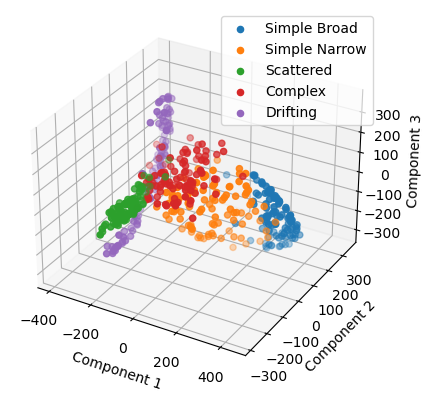

In [95]:
# Separate the transformed data back into classes
pca_per_directory = []
for i in range(len(directories)):
    num_samples = data[i].shape[0]
    start_idx = sum(len(data[j]) for j in range(i))
    end_idx = start_idx + num_samples
    pca_per_directory.append(transformed_fit[start_idx:end_idx, :])

# Create a 3D scatter plot for each class
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

labels = [
    "Simple Broad",
    "Simple Narrow",
    "Scattered",
    "Complex",
    "Drifting"
]


for i, label in enumerate(directories

):
    ax.scatter(pca_per_directory[i][:, 0], pca_per_directory[i][:, 1], pca_per_directory[i][:, 2], label=labels[i])

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.legend()
plt.show()

MovieWriter imagemagick unavailable; using Pillow instead.


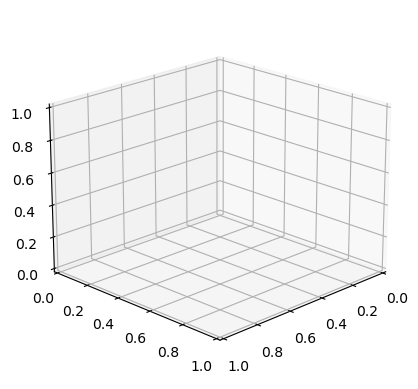

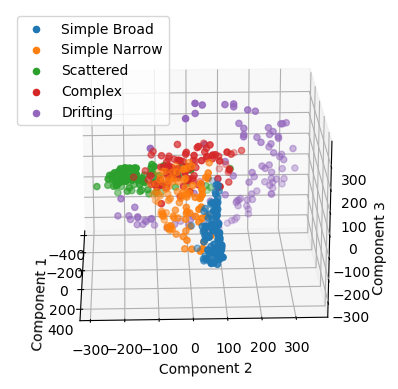

In [96]:
from matplotlib.animation import FuncAnimation

# Separate the transformed data back into classes
pca_per_directory = []
for i in range(len(directories)):
    num_samples = data[i].shape[0]
    start_idx = sum(len(data[j]) for j in range(i))
    end_idx = start_idx + num_samples
    pca_per_directory.append(transformed_fit[start_idx:end_idx, :])

# Create a 3D scatter plot for each class
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Customize the view angle
ax.view_init(elev=20, azim=45)  # Adjust the elevation and azimuth angles

labels = [
    "Simple Broad",
    "Simple Narrow",
    "Scattered",
    "Complex",
    "Drifting"
]


# Create a 3D scatter plot
def update_angle(frame):
    ax.cla()
    ax.view_init(elev=20, azim=frame)
    for i, label in enumerate(directories):
        ax.scatter(
            pca_per_directory[i][:, 0], pca_per_directory[i][:, 1], pca_per_directory[i][:, 2],
            label=labels[i]
        )
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    # Set the desired limits for each axis to zoom in
    # ax.set_xlim([-2, 2])
    # ax.set_ylim([-2, 2])
    # ax.set_zlim([-2, 5]) 
    ax.legend()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Initialize FuncAnimation
ani = FuncAnimation(fig, update_angle, frames=np.arange(0, 360, 2), repeat=True)

# Save the animation as a GIF
ani.save('pca_animation_correct_noise_clipped.gif', writer='imagemagick', fps=15)

plt.show()


## Look at the PCA representation for each component

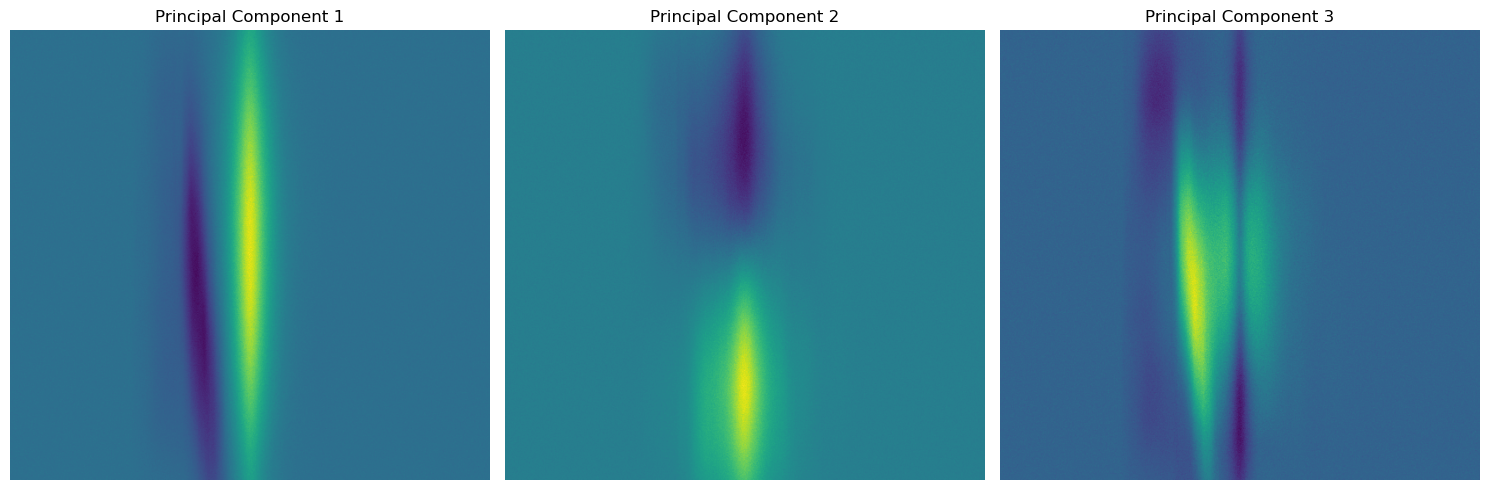

In [21]:
# Get the principal components
principal_components = pca.components_

# Create a subplot for each principal component
n_cols = 3  # Number of columns for subplots
n_rows = 1  # Number of rows for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5))

# Plot each principal component
for i in range(n_components):
    component = principal_components[i].reshape(1024, 512)
    ax = axes[i]
    ax.imshow(component.T, cmap='viridis', aspect='auto')
    ax.set_title(f'Principal Component {i + 1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Look at explained variance as a function of the number of components

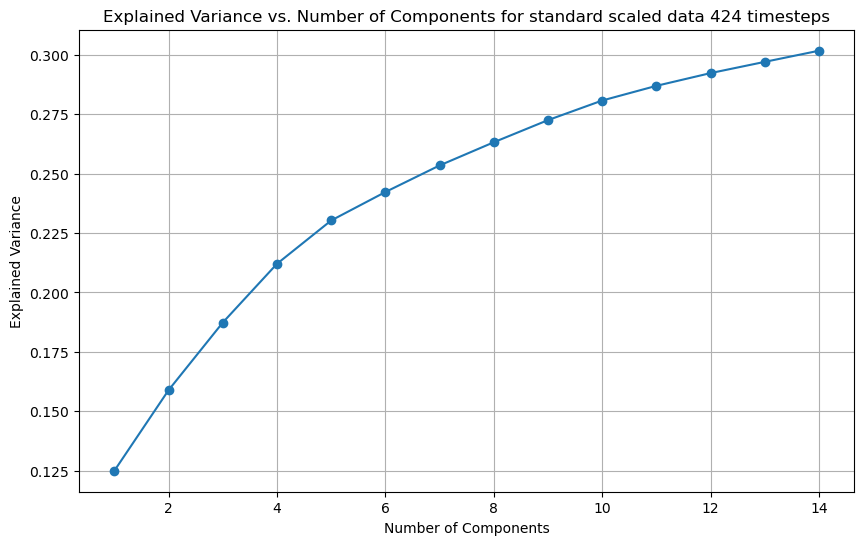

In [239]:
explained_variance = []

for n in range(1, 15):
    pca = PCA(n_components=n)
    pca.fit(combined_data_2d)
    explained_variance.append(np.sum(pca.explained_variance_ratio_))

# Plot the explained variance as a function of the number of components
plt.figure(figsize=(10, 6))
plt.plot(range(1, 15), explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs. Number of Components for standard scaled data 424 timesteps')
plt.grid(True)
plt.show()

In [349]:
# Fit PCA with 5 components
n_components = 5
pca = PCA(n_components=n_components)
pca.fit(combined_data_2d)

# Transform data to the first 5 PCA components
transformed_data = pca.transform(combined_data_2d)
print(transformed_data.shape)

(500, 5)


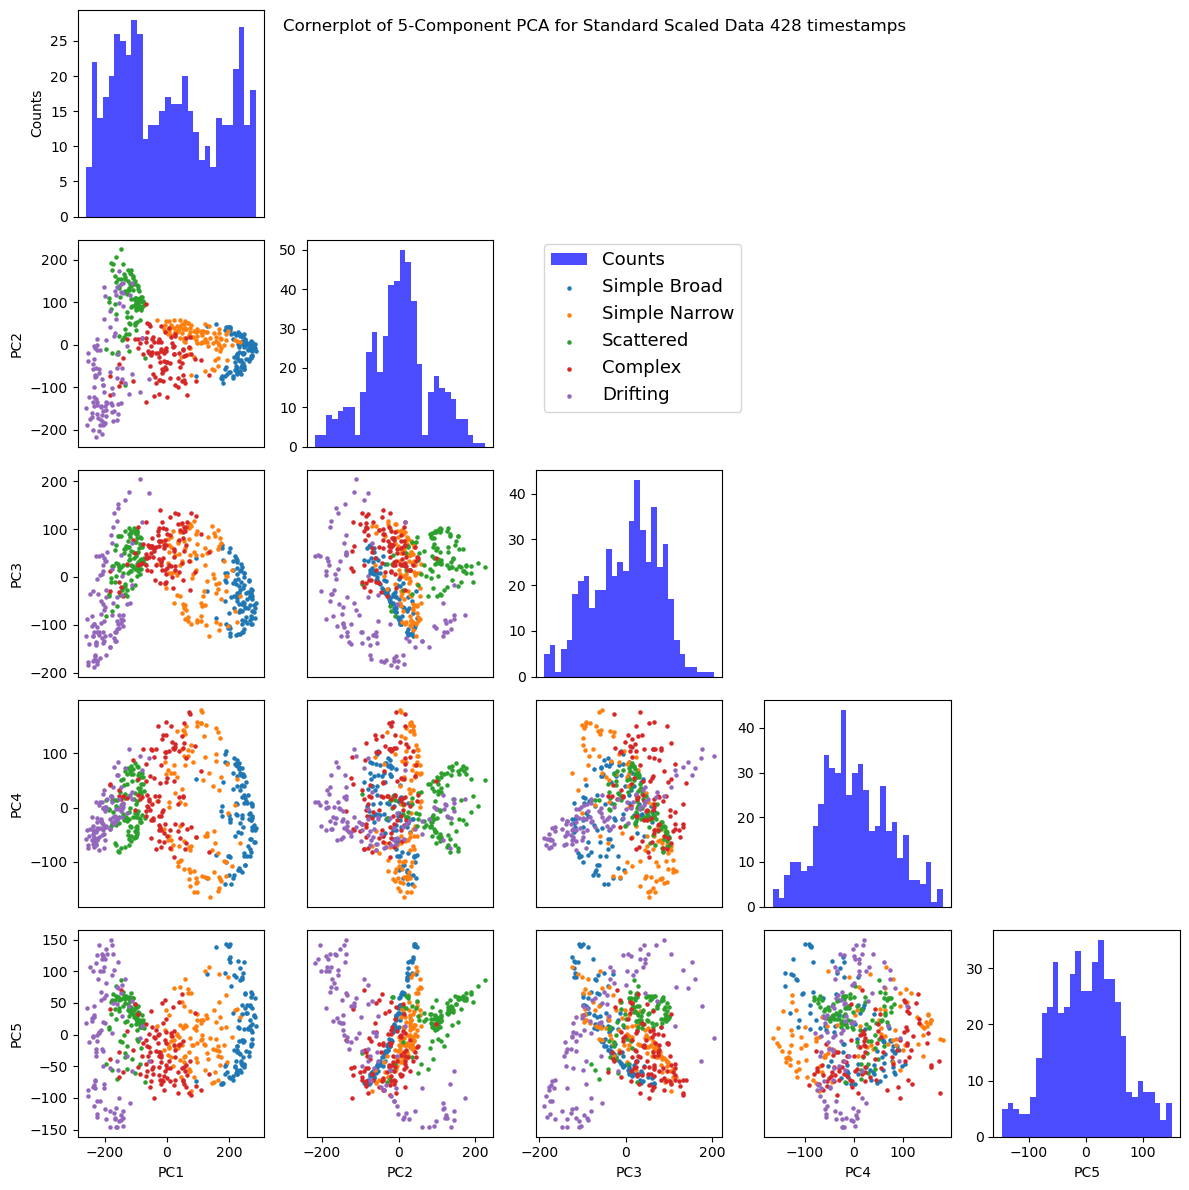

In [417]:
# Create labels for each component
labels = [f"PC{i+1}" for i in range(n_components)]

burst_labels = [
    "Simple Broad",
    "Simple Narrow",
    "Scattered",
    "Complex",
    "Drifting"
]

# Create a square grid of subplots
fig, axes = plt.subplots(n_components, n_components, figsize=(12, 12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

# Plot histograms on the diagonal
for i in range(n_components):
    axes[i, i].hist(transformed_data[:, i], bins=30, color='blue', alpha=0.7)
    if i == 0:
        axes[i, i].set_ylabel('Counts')
    if i == n_components - 1:
        axes[i, i].set_xlabel(labels[i])
        axes[i, i].tick_params(axis='x', bottom=True, top=False)
    else:
        axes[i, i].tick_params(axis='x', bottom=False, top=False, labelbottom=False)
        

# Plot scatter plots on the off-diagonal
for i in range(n_components):
    for j in range(i + 1, n_components):
        for k, label in enumerate(directories):
            num_samples = data[k].shape[0]
            start_idx = sum(len(data[m]) for m in range(k))
            end_idx = start_idx + num_samples
            axes[i, j].set_axis_off()
            axes[j, i].scatter(transformed_data[start_idx:end_idx, i], transformed_data[start_idx:end_idx, j], label=burst_labels[k], s=5)
        if i == 0:
            axes[j, i].set_ylabel(labels[j])
            axes[j, i].tick_params(axis='y', left=True, right=False)
        else:
            axes[j, i].tick_params(axis='y', left=False, right=False, labelleft=False)

        # Adjust y-axis labels and ticks
        if j == n_components - 1:
            axes[j, i].set_xlabel(labels[i])
            axes[j, i].tick_params(axis='x', bottom=True, top=False)
        else:
            axes[j, i].tick_params(axis='x', bottom=False, top=False, labelbottom=False)
            
# Add legend outside the subplots
fig.legend([
    "Counts",
    "Simple Broad",
    "Simple Narrow",
    "Scattered",
    "Complex",
    "Drifting"
],loc='upper left', bbox_to_anchor=(0.45, 0.8), fontsize='13')

# Adjust layout for better visualization
plt.tight_layout()

plt.suptitle("Cornerplot of 5-Component PCA for Standard Scaled Data 428 timestamps")

# Show the plot
plt.show()

